# Lo Split
A five-minute tutorial.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm
from matplotlib_venn import venn3

import lohi_splitter as lohi

In [2]:
# Load Ki values for DRD2
drd2 = pd.read_csv('data/drd2_lo.csv', index_col=0)
drd2

,smiles,value
0,Brc1ccc(-[n+]2cc[n+](Cc3ccccc3)cc2)c2cc[nH]c12,7.717691
1,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,5.283913
2,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,7.437357
3,Brc1ccc(NCCN2CCN(CCc3c[nH]c4ccccc34)CC2)cc1,7.288705
4,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,6.035740
...,...,...
5414,c1cnc(N2CCN(CCCOc3ccc(-c4nc5ccccc5[nH]4)cc3)CC...,6.568636
5415,c1cnc(N2CCN(CCCOc3ccc(-c4nc5ccccc5o4)cc3)CC2)nc1,6.701147
5416,c1cnc(N2CCN(CCCSc3nc4ccccc4s3)CC2)nc1,6.273273
5417,c1cnc(N2CCN(Cc3c[nH]c4ncccc34)CC2)nc1,5.931443


# Lo, Train-Test
There are works (especially in molecular generation) that assume their predictive models can distinguish minor modifications of molecules. "Lo" (Lead Optimization) is a split designed to simulate that scenario. It divides a dataset into two parts: test clusters and train. The test clusters consist of similar molecules, and one of those molecules is placed in the training set to imitate a known hit.

Furthermore, the properties of molecules are measured with noise. We want to test if a predictive model can rank molecules within a cluster, but it doesn't make sense to test it in clusters where variability is dominated by measurement noise. Thus, the Lo splitter selects clusters with significant variability in properties.

In [4]:
smiles = drd2['smiles'].to_list()
values = drd2['value'].to_list()

# Similarity threshold for clustering molecules.
# Molecules are considered similar if their ECFP4 Tanimoto Similarity is larger than this threshold.
threshold=0.4

## The minimum number of molecules required in a cluster.
min_cluster_size=5

# Maximum number of clusters to be created. Any additional molecules are added to the training set.
max_clusters=50

# Minimum standard deviation of values within a cluster.
# This ensures that clusters with too little variability are filtered out.
# For further details, refer to Appendix B of the paper.
std_threshold=0.60

cluster_smiles, train_smiles = lohi.lo_train_test_split(smiles=smiles, 
                                                        threshold=threshold, 
                                                        min_cluster_size=min_cluster_size, 
                                                        max_clusters=max_clusters, 
                                                        values=values, 
                                                        std_threshold=std_threshold)


In [5]:
# It is just handy util to build pandas DataFrame
split = lohi.set_cluster_columns(drd2, cluster_smiles, train_smiles)

# cluster 0 means train
split

,smiles,value,cluster
0,Brc1ccc(-[n+]2cc[n+](Cc3ccccc3)cc2)c2cc[nH]c12,7.717691,1
1,Brc1ccc(CNCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,5.283913,0
2,Brc1ccc(N2CCN(Cc3ccccc3)CC2)c2cc[nH]c12,7.437357,0
4,Brc1ccc(NCCN2CCN(Cc3cc4ccccc4[nH]3)CC2)cc1,6.035740,47
7,C#CC1=CCC(N(CCC)CCC)CC1,6.583678,0
...,...,...,...
5409,c1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1S2,7.420216,35
5410,c1ccc2oc(-c3ccc(OCCCN4CCN(c5nsc6ccccc56)CC4)cc...,6.055468,0
5413,c1cnc(N2CCN(CCCCc3nc4ccccc4s3)CC2)nc1,7.560667,37
5417,c1cnc(N2CCN(Cc3c[nH]c4ncccc34)CC2)nc1,5.931443,15


Text(0.5, 1.0, 'STD per cluster')

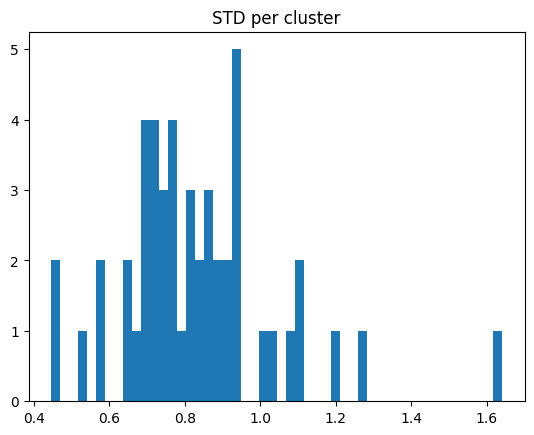

In [6]:
# Let's plot distribution of std per cluster
per_cluster_std = []
for i in range(1, split['cluster'].max()):
    cluster = split[split['cluster'] == i]
    std = cluster['value'].std()
    per_cluster_std.append(std)
plt.hist(per_cluster_std, bins=50)
plt.title('STD per cluster')

# Lo Split with k-fold
To create k-folds, one simple approach is to shuffle the data first.

In [7]:
splits = []

smiles = np.array(drd2['smiles'].to_list())
values = np.array(drd2['value'].to_list())

for i in tqdm(range(3)):
    idx = np.arange(len(smiles))
    np.random.seed(i)
    np.random.shuffle(idx)

    shuffled_smiles = smiles[idx]
    shuffled_values = values[idx]
    cluster_smiles, train_smiles = lohi.lo_train_test_split(smiles=shuffled_smiles, 
                                                        threshold=threshold, 
                                                        min_cluster_size=min_cluster_size, 
                                                        max_clusters=max_clusters, 
                                                        values=shuffled_values, 
                                                        std_threshold=std_threshold)
    split = lohi.set_cluster_columns(drd2, cluster_smiles, train_smiles)
    splits.append(split)

100%|██████████| 3/3 [05:12<00:00, 104.13s/it]


In [8]:
data = splits[0]
test_0 = data[data['cluster'] != 0]['smiles'].to_list()

data = splits[1]
test_1 = data[data['cluster'] != 0]['smiles'].to_list()

data = splits[2]
test_2 = data[data['cluster'] != 0]['smiles'].to_list()

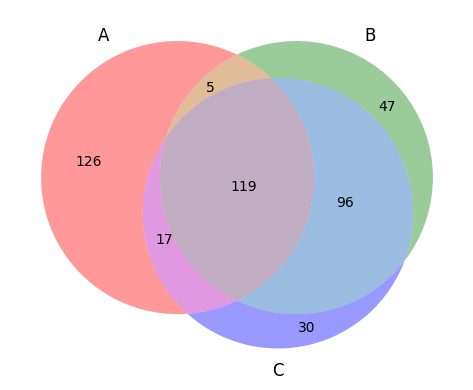

In [9]:
venn3([
    set(test_0),
    set(test_1),
    set(test_2),
])